In [12]:
import os 
import pandas as pd
import pickle
import re
from operator import itemgetter
import random
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib import pyplot as plt
%matplotlib inline

# Define os parametros necessarios para o teste

class Parametros:
    def __init__(self, seed, length, a, b, n_calls, band, modulacao):
        self.seed = seed
        self.length = length
        self.a = a
        self.b = b
        self.n_calls = n_calls
        self.band = band
        self.modulacao = modulacao
        
# Lê arquivo de data utilizado
        
    def gera_data(self):
        a_file = open("data.pkl", "rb")
        return pickle.load(a_file)
        
# Gera o vetor de SNR
        
    def gera_vetor_snr(self):
        random.seed(self.seed)
        sinalRuido = []
        for i in range(0, self.length):
            sinalRuido.append(round(random.uniform(self.a, self.b), 1))
        return sinalRuido
    
# Calcula a banda requerida para cada chamada
    
    def calcula_banda_requerida(self, rate):
        # codecRate = 64 # Kbps
        codecPayload = 160  # Bytes
        pps = 50 # milisegundos
        cabecalhoIP = 40 # Bytes 
        return ((((codecPayload * rate + cabecalhoIP) * 8) * pps) / 1000) * self.n_calls
    
# Busca o resultado no dataset baseado nos parametros de teste 
    
    def busca_resultados(self, snr):
        availableConfigs = []
        bandwidth_results = []

        for mod, param in self.gera_data().items():
            if mod == self.modulacao:
                if snr in param.keys():
                    for tupla in param.get(snr):
                        rate = tupla[3]
                        if self.calcula_banda_requerida(rate) <= self.band:
                            availableConfigs.append(tupla)
        return availableConfigs


# Ordena um resultado (lista de tuplas) pelo maior MOS

    def ord_maior_mos(self, lista_de_tuplas):
        return sorted(lista_de_tuplas, key=lambda element: element[0], reverse=True)


# Ordena um resultado (lista de tuplas) pelo menor rate

    def ord_menor_rate(self, lista_de_tuplas):
        return sorted(lista_de_tuplas, key=lambda element: element[3])
        

# Gera a tabela com o resultado dos testes

    def gera_dataset_resultado(self, lista_resultado, vetor_snr):
        bandwidth_results = []
        for i in lista_resultado:
            rate = i[3]
            bandwidth_results.append(self.calcula_banda_requerida(rate))
        df0 = pd.DataFrame(bandwidth_results, columns =["BANDWIDTH"])
        df1 = pd.DataFrame(lista_resultado, columns =['MOS', 'BER', 'FEC', 'RATE'])
        df2 = pd.DataFrame(vetor_snr, columns=['SNR'])
        df2['TIME'] = df2.reset_index().index
        return pd.concat([df2, df1, df0], axis=1, sort=False)


# Gera os gráficos de resultados de teste
        
    def gera_graficos(self, dataset, x, y):
        sns.set(style="darkgrid")
        sns.lineplot(x=x, y=y, data=dataset)
        
    
class Teste(Parametros):
#     def __init__(self, modulacao, band):
#         super().__init__(modulacao, band)


    def modelo_adaptativo(self):
        results = []
        vetor_snr = []
        for snr in self.gera_vetor_snr():
            vetor_snr.append(snr)
            lista_de_tuplas = self.busca_resultados(snr)

            # Se maior resultado de MOS for menor do que 2.58, 
            # retorna configuração com menor rate [prioridade largura de banda]

            if self.ord_maior_mos(lista_de_tuplas)[0][0] < 2.58:
                results.append(self.ord_menor_rate(lista_de_tuplas)[0])

            # Se maior resultado de MOS estiver maior do que 4.03,
            # seleciona todas configurações com valor acima de 4.03 e seleciona com menor rate [prioridade largura de banda]  
             
            elif self.ord_maior_mos(lista_de_tuplas)[0][0] > 4.03:
                temp = []
                for tupla in lista_de_tuplas:
                    if tupla[0] > 4.03:
                        temp.append(tupla)
                results.append(self.ord_menor_rate(temp)[0])
                temp.clear()

            # Caso contrario é escolhido o maior resultado de MOS com o menor rate [prioridade MOS] 
            
            else:
                results.append(self.ord_maior_mos(self.ord_menor_rate(lista_de_tuplas))[0]) 
        tabela_completa = self.gera_dataset_resultado(results, vetor_snr)
        print("Banda média requerida =", round(tabela_completa['BANDWIDTH'].mean(), 3), "Kbp/s", "\n")
        print("MOS médio =", round(tabela_completa['MOS'].mean(), 3), "\n")
        return self.gera_graficos(tabela_completa, "TIME", "MOS")



    def modelo_fixo(self, **kwargs):
        results = []
        vetor_snr = []
        if kwargs.get('code') == False:
            pattern = 'No Code'
        else:
            try:
                n = kwargs['n']
                k = kwargs['k']
            except:
                return []
            pattern = 'RS('+ str(n) + ', ' + str(k) + ')'
        for snr in self.gera_vetor_snr():
            vetor_snr.append(snr)
            for element in self.busca_resultados(snr):
                if element[2] == pattern:
                    results.append(element)
        tabela_completa = self.gera_dataset_resultado(results, vetor_snr)
        print("Banda média requerida =", round(tabela_completa['BANDWIDTH'].mean(), 3), "Kbp/s", "\n")
        print("MOS médio =", round(tabela_completa['MOS'].mean(), 3), "\n")
        return self.gera_graficos(tabela_completa, "TIME", "MOS")



    # def compara_modelos(self, **kwargs):
    #     test1 = self.modelo_adaptativo()
    #     test2 = self.modelo_fixo(**kwargs)
    #     return test1, test2

In [9]:
# Args: | Seed | Tamanho Vetor SNR | Valor inicial | Valor final | Arquivo de dados | Modulação |
resultado = Teste(0, 200, 3, 20, 1, 100, 'BPSK')

Banda média requerida = 82.058 Kbp/s 

MOS médio = 4.213 



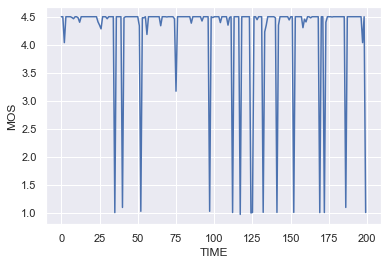

In [10]:
resultado.modelo_adaptativo()

Banda média requerida = 98.286 Kbp/s 

MOS médio = 4.235 



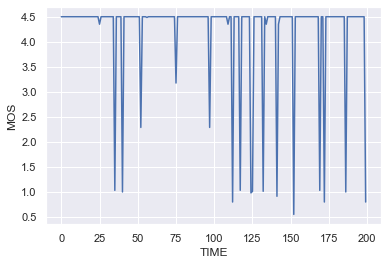

In [11]:
resultado.modelo_fixo(code=True, n=360, k=280)